In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.reasoner import *
from src.generate import *
from src.utils import *
from src.vis import *

seed = 2022

In [3]:
onto_paths = 'african-wildlife.ofn exchangemodel-noimport.ofn stuff-noimport.ofn swo-noimport.ofn ontodt-noimport.ofn pizza.ofn'.split()
onto_names = 'wildlife demacare stuff swo ontodt pizza'.split()
ontos = []
facts = []
for path in onto_paths:
    onto = load_ofn('local/out/dataset/' + path, silent=True)
    fact = Reasoner.from_onto(onto, timeout=None)
    facts.append(fact)
    ontos.append(onto)
    print(path, '\t', onto)

african-wildlife.ofn 	 <Onto 30 concepts, 5 roles, 49 axioms>
exchangemodel-noimport.ofn 	 <Onto 260 concepts, 53 roles, 369 axioms>
stuff-noimport.ofn 	 <Onto 192 concepts, 46 roles, 314 axioms>


FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


swo-noimport.ofn 	 <Onto 4067 concepts, 39 roles, 7140 axioms>
ontodt-noimport.ofn 	 <Onto 405 concepts, 8 roles, 921 axioms>
pizza.ofn 	 <Onto 99 concepts, 4 roles, 287 axioms>


In [4]:
def make_dataset(onto, fact, n_queries=32_000):
    rng = np.random.default_rng(seed)
    Nc, Nr = onto.n_concepts, onto.n_roles
    gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=4, p_atomic=0.95)

    queries, answers, qset = [], [], set()
    while len(queries) < n_queries:
        axiom = gen()
        axiom_core = core(axiom)
        if axiom_core in qset: continue
        answer = fact.check_axiom(axiom)
        queries.append(axiom_core); answers.append(int(answer)); qset.add(axiom_core)
        
    return queries, answers

idx_te, X_te, y_te = [], [], []
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    X_te_onto, y_te_onto = make_dataset(onto, fact)
    idx_te += [i]*len(X_te_onto)
    print(onto_name, '- balance', np.round(np.mean(y_te_onto), 4))
    X_te += X_te_onto
    y_te += y_te_onto
    
rng = np.random.default_rng(seed)
data = idx_te, X_te, y_te = jointshuffle(rng, idx_te, X_te, y_te)

wildlife - balance 0.1202
demacare - balance 0.0426
stuff - balance 0.2309
swo - balance 0.2878
ontodt - balance 0.0893
pizza - balance 0.4109


In [5]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)

T.manual_seed(seed)
unfrozen_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
unfrozen_r_head = ReasonerHead(**head_params)

T.manual_seed(seed)
modified_embs = ModifiedEmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
modified_r_head = ModifiedReasonerHead(**head_params)


print('unfrozen reasoner head')
T.manual_seed(seed)
unfrozen_log = train(data, None, unfrozen_r_head, unfrozen_r_embs, run_name='unfrozen', **train_params)

print('----')

print('modified reasoner head ')
T.manual_seed(seed)
modified_log = train_mod(data, None, modified_r_head, modified_embs, run_name='modified', epoch_count=6, batch_size=32, not_nn_loss_weight=100, and_nn_loss_weight=50)

modified_r_head.intertrain_not_and()
modified_log = train_mod(data, None, modified_r_head, modified_embs, run_name='modified', epoch_count=4, batch_size=32, not_nn_loss_weight=100, and_nn_loss_weight=50,not_nn_loss_weight=100, top_bot_weight=18, and_nn_loss_weight=40, train_top_bot=True)


unfrozen reasoner head
train epoch 00/10 | batch 6001/6000 | loss 0.6852 | val loss 0.6852 | acc 0.6468 | f1 0.3700 | prec 0.2852 | recall 0.5267 | roc auc 0.6506 | pr auc 0.2622 | elapsed 80.79s
train epoch 01/10 | batch 6001/6000 | loss 0.3458 | val loss 0.2042 | acc 0.9283 | f1 0.8052 | prec 0.8651 | recall 0.7531 | roc auc 0.9539 | pr auc 0.8778 | elapsed 354.97s
train epoch 02/10 | batch 6001/6000 | loss 0.1839 | val loss 0.1598 | acc 0.9449 | f1 0.8546 | prec 0.8903 | recall 0.8217 | roc auc 0.9710 | pr auc 0.9180 | elapsed 301.81s
train epoch 03/10 | batch 6001/6000 | loss 0.1555 | val loss 0.1407 | acc 0.9518 | f1 0.8744 | prec 0.8976 | recall 0.8524 | roc auc 0.9775 | pr auc 0.9339 | elapsed 237.35s
train epoch 04/10 | batch 6001/6000 | loss 0.1400 | val loss 0.1287 | acc 0.9559 | f1 0.8852 | prec 0.9085 | recall 0.8630 | roc auc 0.9810 | pr auc 0.9434 | elapsed 242.06s
train epoch 05/10 | batch 6001/6000 | loss 0.1287 | val loss 0.1180 | acc 0.9600 | f1 0.8967 | prec 0.9117 |

ValueError: too many values to unpack (expected 3)

In [11]:
print('modified reasoner head ')
T.manual_seed(seed)
modified_log = train_mod(data, None, modified_r_head, modified_embs, run_name='modified', epoch_count=6, batch_size=32, not_nn_loss_weight=100, and_nn_loss_weight=50)

modified_r_head.intertrain_not_and()
modified_log = train_mod(data, None, modified_r_head, modified_embs, run_name='modified', epoch_count=4, batch_size=32, not_nn_loss_weight=100, and_nn_loss_weight=50, top_bot_weight=18, train_top_bot=True)

modified reasoner head 
train epoch 0/6 | batch 6001/6000 | loss 3.5241 | val loss 0.6438 | acc 0.8030 | f1 0.0000 | prec 0.0000 | recall 0.0000 | roc auc 0.5323 | pr auc 0.2242 | elapsed 196.97s
train epoch 1/6 | batch 6001/6000 | loss 1.5225 | val loss 0.3549 | acc 0.8503 | f1 0.4944 | prec 0.7383 | recall 0.3716 | roc auc 0.8513 | pr auc 0.6517 | elapsed 405.21s
train epoch 2/6 | batch 6001/6000 | loss 1.0874 | val loss 0.1963 | acc 0.9248 | f1 0.7913 | prec 0.8725 | recall 0.7240 | roc auc 0.9575 | pr auc 0.8841 | elapsed 361.79s
train epoch 3/6 | batch 6001/6000 | loss 1.0526 | val loss 0.1568 | acc 0.9436 | f1 0.8503 | prec 0.8912 | recall 0.8130 | roc auc 0.9728 | pr auc 0.9210 | elapsed 305.24s
train epoch 4/6 | batch 6001/6000 | loss 1.0350 | val loss 0.1383 | acc 0.9510 | f1 0.8706 | prec 0.9075 | recall 0.8366 | roc auc 0.9787 | pr auc 0.9360 | elapsed 308.70s
train epoch 5/6 | batch 6001/6000 | loss 1.0171 | val loss 0.1259 | acc 0.9570 | f1 0.8887 | prec 0.9063 | recall 0.

SyntaxError: keyword argument repeated: not_nn_loss_weight (1367868766.py, line 9)

In [12]:
modified_log = train_mod(data, None, modified_r_head, modified_embs, run_name='modified', epoch_count=4, batch_size=32, not_nn_loss_weight=100, and_nn_loss_weight=50, top_bot_weight=18, train_top_bot=True)

train epoch 0/4 | batch 6001/6000 | loss 9.0779 | val loss 0.3891 | acc 0.8384 | f1 0.6936 | prec 0.5535 | recall 0.9287 | roc auc 0.9440 | pr auc 0.8116 | elapsed 369.15s
train epoch 1/4 | batch 6001/6000 | loss 8.8120 | val loss 0.1162 | acc 0.9602 | f1 0.8975 | prec 0.9095 | recall 0.8859 | roc auc 0.9846 | pr auc 0.9521 | elapsed 402.37s
train epoch 2/4 | batch 6001/6000 | loss 8.9803 | val loss 0.1018 | acc 0.9647 | f1 0.9097 | prec 0.9173 | recall 0.9023 | roc auc 0.9879 | pr auc 0.9637 | elapsed 443.58s
train epoch 3/4 | batch 6001/6000 | loss 9.2152 | val loss 0.0893 | acc 0.9700 | f1 0.9226 | prec 0.9392 | recall 0.9066 | roc auc 0.9904 | pr auc 0.9720 | elapsed 432.63s
train epoch 4/4 | batch 6001/6000 | loss 9.3272 | val loss 0.0784 | acc 0.9742 | f1 0.9334 | prec 0.9477 | recall 0.9195 | roc auc 0.9923 | pr auc 0.9775 | elapsed 515.07s


local/out/exp/20240701T200720
------
Unfrozen reasoner head
train time 2438.175719022751
           mean     std   micro
acc      0.9733  0.0160  0.9733
prec     0.9349  0.0598  0.9392
recall   0.8901  0.0854  0.9244
f1       0.9110  0.0674  0.9317
auc_roc  0.9891  0.0094  0.9925
auc_pr   0.9580  0.0415  0.9775


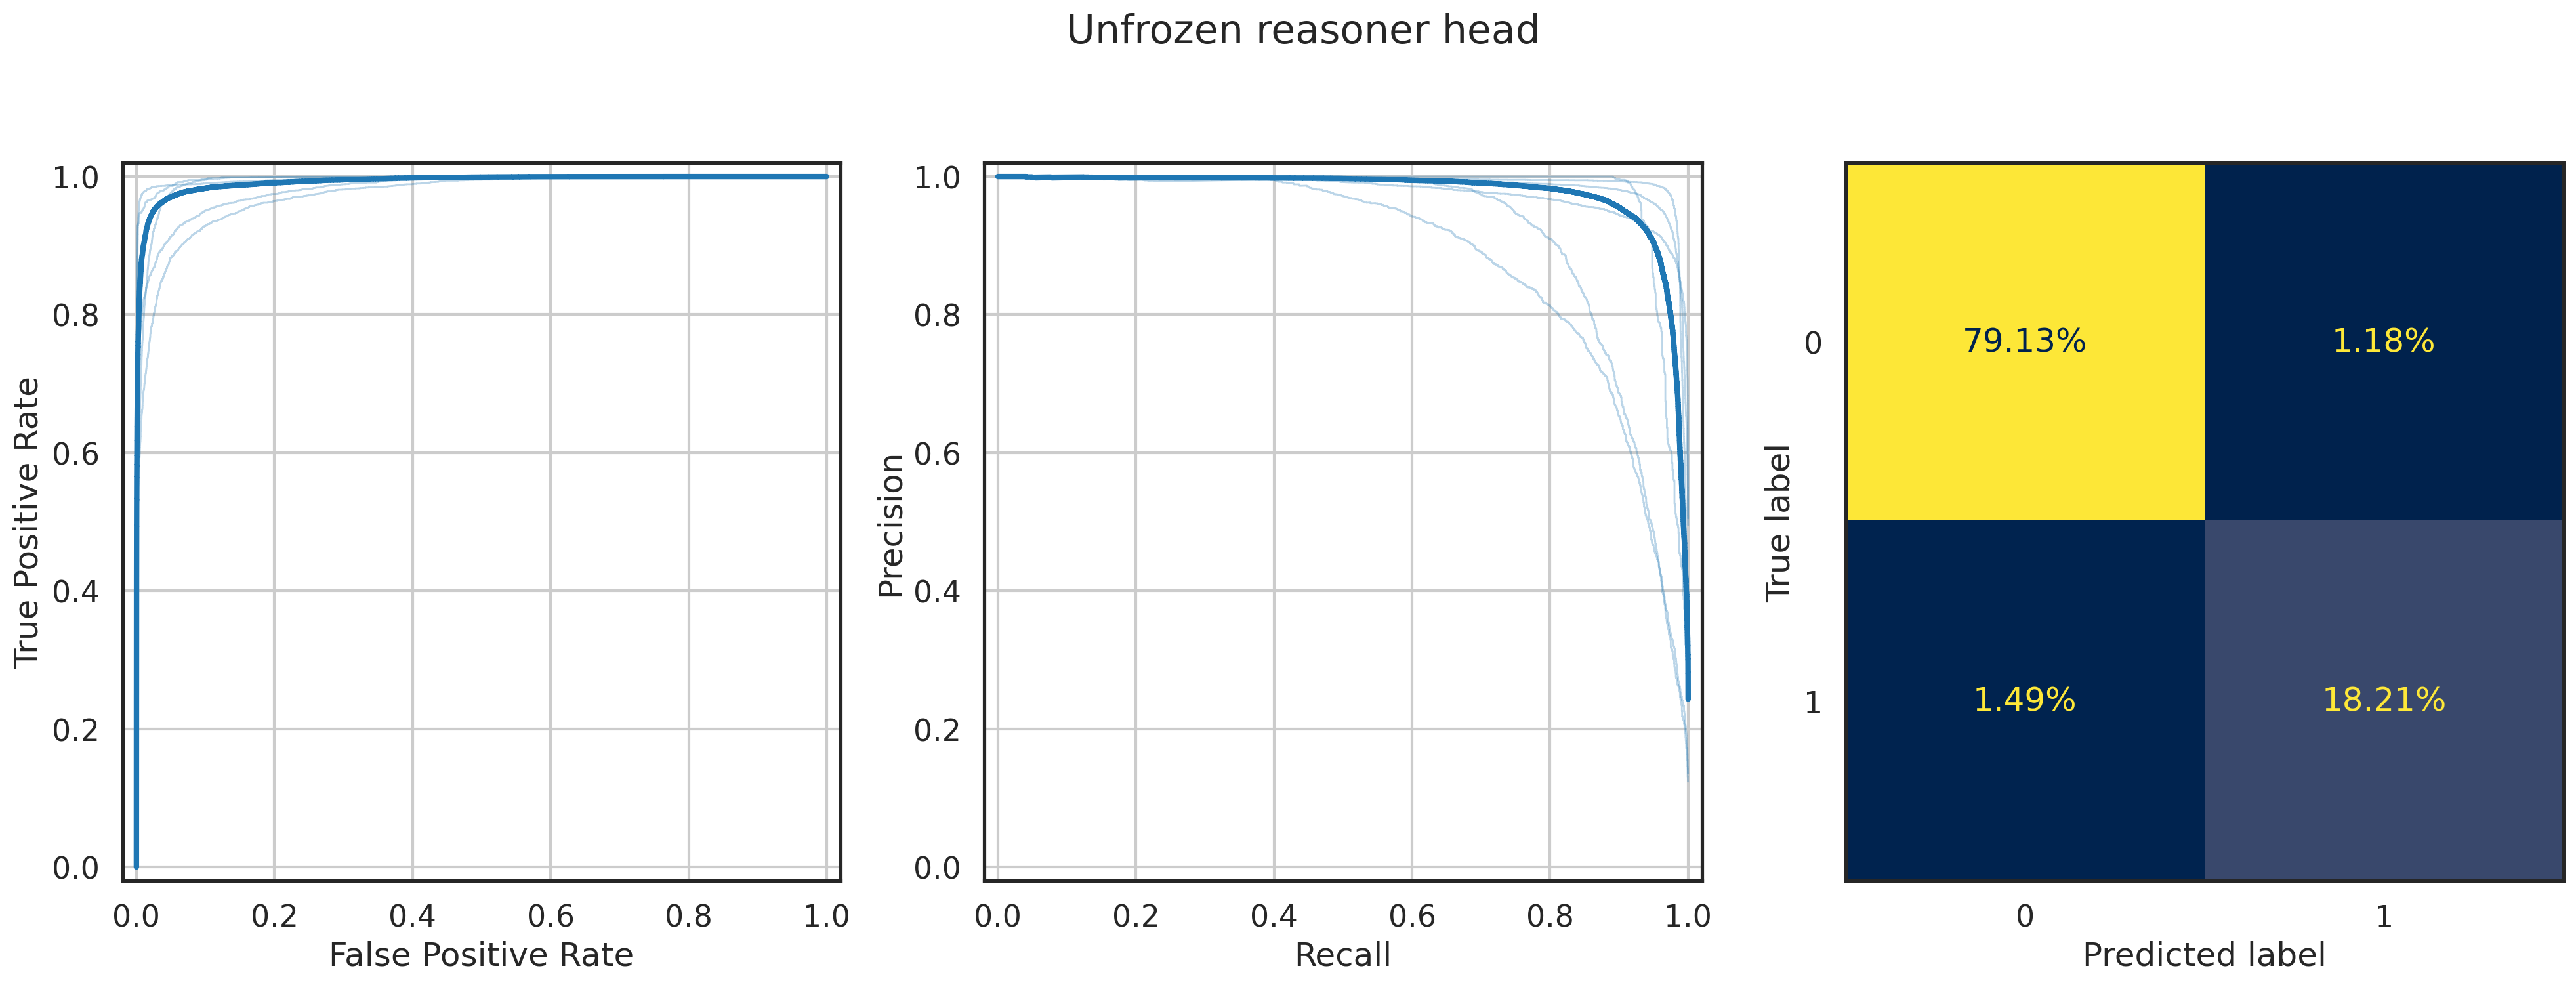

In [16]:
titles = 'Expected', 'Unfrozen reasoner head', 'Modified reasoner head'
logs = unfrozen_log, modified_log
heads = unfrozen_r_head, modified_r_head
embeddings = unfrozen_r_embs, modified_embs

base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

for head, embs, log, title in zip(heads, embeddings, logs, titles[1:2]):
    print('------')
    with T.no_grad():
        head.eval()
        _, _, Y_te = eval_batch(head, embs, X_te, y_te, idx_te)
    print(title)
    
    history_tr = pd.DataFrame(log.history_tr)
    test_history_by_onto = pd.DataFrame(log.history_vl_by_onto)
    test_history = pd.DataFrame(log.history_vl)
    test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te=Y_te))
    test_history.to_csv(base+f'/{title} test.csv', index=False)
    test_history_by_onto.to_csv(base+f'/{title} test by onto.csv', index=False)
    test_results.to_csv(base+f'/{title} test clas.csv', index=False)

    print('train time', history_tr.groupby('epoch').max().elapsed.sum())
    print(report(ontos, y_te, Y_te, idx_te).round(4))
    plt.suptitle(title)

local/out/exp/20240701T200720
------
Modified reasoner head
train time 1875.9462027549744
           mean     std   micro
acc      0.9742  0.0145  0.9742
prec     0.9469  0.0377  0.9477
recall   0.8851  0.0909  0.9195
f1       0.9137  0.0629  0.9334
auc_roc  0.9889  0.0090  0.9923
auc_pr   0.9598  0.0383  0.9775


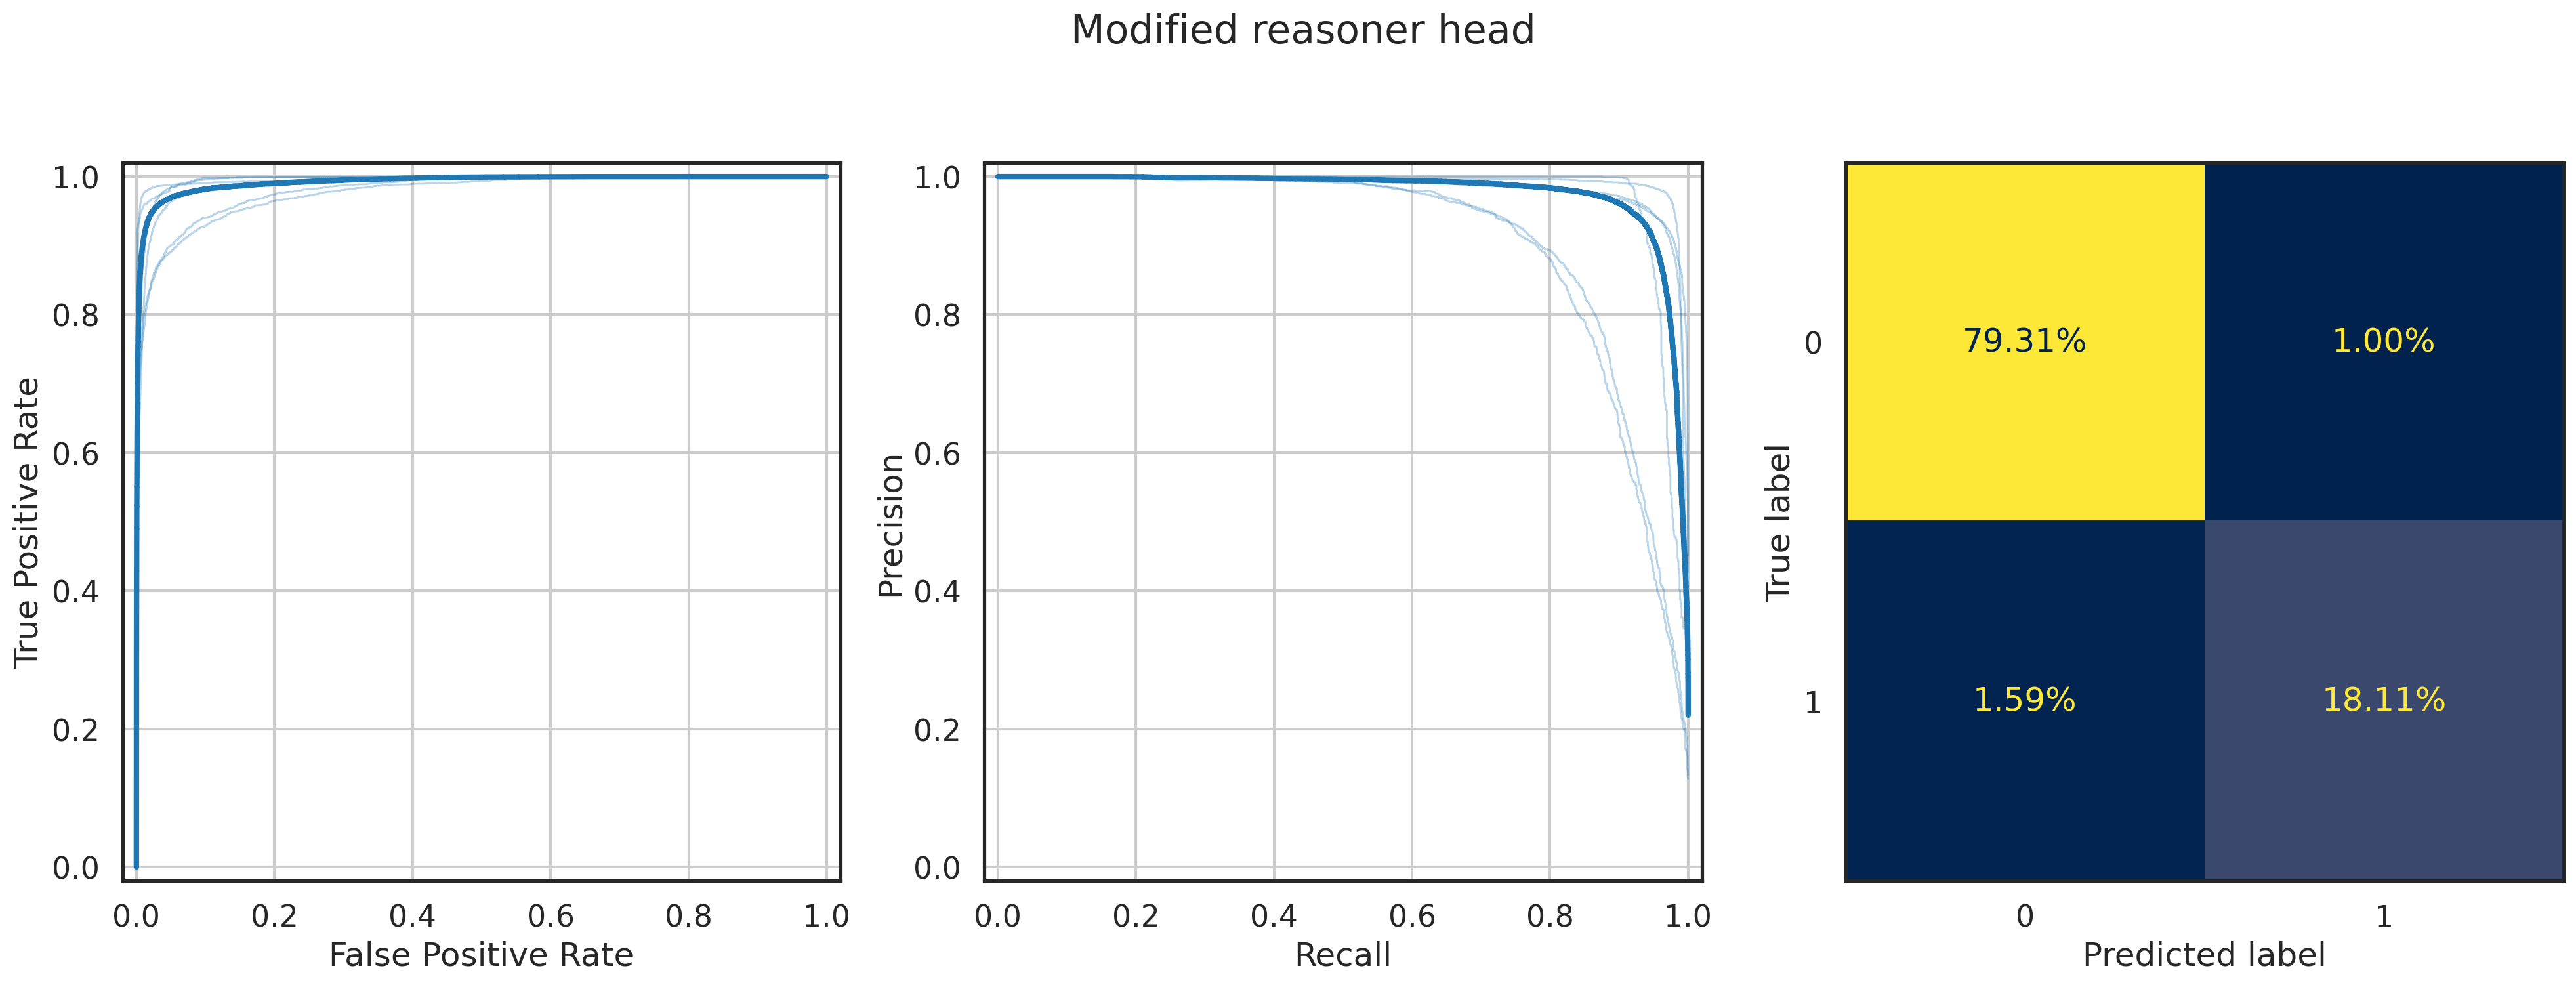

In [23]:
titles = 'Expected', 'Unfrozen reasoner head', 'Modified reasoner head'
logs = unfrozen_log, modified_log
heads = unfrozen_r_head, modified_r_head
embeddings = unfrozen_r_embs, modified_embs

base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

for head, embs, log, title in zip(heads[1:], embeddings[1:], logs[1:], titles[2:]):
    print('------')
    with T.no_grad():
        head.eval()
        _, _, Y_te = eval_batch_mod(head, embs, X_te, y_te, idx_te)
    print(title)
    
    history_tr = pd.DataFrame(log.history_tr)
    test_history_by_onto = pd.DataFrame(log.history_vl_by_onto)
    test_history = pd.DataFrame(log.history_vl)
    test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te=Y_te))
    test_history.to_csv(base+f'/{title} test.csv', index=False)
    test_history_by_onto.to_csv(base+f'/{title} test by onto.csv', index=False)
    test_results.to_csv(base+f'/{title} test clas.csv', index=False)

    print('train time', history_tr.groupby('epoch').max().elapsed.sum())
    print(report(ontos, y_te, Y_te, idx_te).round(4))
    plt.suptitle(title)

In [24]:
for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    df = pd.DataFrame(log.history_vl_by_onto)
    df = df[df.epoch == df.epoch.max()].drop(columns=['epoch', 'run', 'elapsed'])
    df.onto = df.onto.map(onto_names.__getitem__)
    print('-'*10)
    print(title)
    #print(df.agg(['mean', 'std']).round(4).T)
    print(df.round(4))

----------
Unfrozen reasoner head
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9547  0.8058  0.8308  0.7822   0.9731  0.8914  wildlife
61  0.9955  0.9444  0.9959  0.8979   0.9981  0.9777  demacare
62  0.9884  0.9747  0.9835  0.9660   0.9962  0.9894     stuff
63  0.9622  0.9355  0.9180  0.9537   0.9925  0.9798       swo
64  0.9751  0.8491  0.9231  0.7861   0.9828  0.9207    ontodt
65  0.9642  0.9563  0.9579  0.9548   0.9919  0.9890     pizza
----------
Modified reasoner head
       acc      f1    prec  recall  roc_auc  pr_auc      onto
24  0.9638  0.8398  0.8979  0.7887   0.9759  0.9138  wildlife
25  0.9959  0.9492  0.9984  0.9046   0.9978  0.9763  demacare
26  0.9866  0.9708  0.9793  0.9624   0.9961  0.9899     stuff
27  0.9698  0.9478  0.9419  0.9538   0.9949  0.9868       swo
28  0.9719  0.8273  0.9159  0.7543   0.9802  0.9076    ontodt
29  0.9570  0.9476  0.9482  0.9470   0.9888  0.9844     pizza


In [82]:
input = T.rand(10)

print(input)
print(modified_r_head.and_nn(im_mod( input, input)))
F.mse_loss(input, modified_r_head.and_nn(im_mod(input, input)))

tensor([0.0670, 0.1708, 0.2225, 0.8909, 0.1699, 0.4522, 0.0137, 0.1377, 0.4405,
        0.3273])
tensor([0.0719, 0.1380, 0.1540, 0.8493, 0.3007, 0.4371, 0.0312, 0.1777, 0.2694,
        0.2431], grad_fn=<AddBackward0>)


tensor(0.0063, grad_fn=<MseLossBackward0>)

In [28]:
print(T.round(T.matmul( modified_r_head.not_nn.weight, modified_r_head.not_nn.weight)*100)/100)

tensor([[1., 0., 0., 0., -0., -0., -0., 0., 0., -0.],
        [0., 1., 0., 0., 0., 0., -0., -0., -0., 0.],
        [-0., 0., 1., 0., -0., -0., 0., 0., 0., -0.],
        [0., 0., 0., 1., -0., 0., 0., -0., -0., 0.],
        [-0., 0., -0., -0., 1., 0., -0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., -0.],
        [-0., 0., -0., 0., -0., 0., 1., 0., 0., 0.],
        [-0., 0., 0., 0., -0., 0., 0., 1., 0., 0.],
        [-0., 0., -0., -0., -0., 0., 0., 0., 1., 0.],
        [-0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], grad_fn=<DivBackward0>)


In [30]:
input = T.rand(10)
print(input)
output = modified_r_head.not_nn(modified_r_head.not_nn(input))
print(output)
print(F.mse_loss(input, output))

tensor([0.7414, 0.6836, 0.7041, 0.4188, 0.6509, 0.1737, 0.5608, 0.6939, 0.7567,
        0.5328])
tensor([0.7420, 0.6843, 0.7060, 0.4199, 0.6493, 0.1777, 0.5604, 0.6971, 0.7533,
        0.5366], grad_fn=<SqueezeBackward3>)
tensor(6.0093e-06, grad_fn=<MseLossBackward0>)


In [48]:
print(modified_r_head.bot_concept[0])
output = modified_r_head.not_nn(modified_r_head.top_concept[0])
print(output)
print(F.mse_loss(modified_r_head.bot_concept[0], output))

tensor([-0.0063, -0.5004,  0.2429, -0.1577, -0.2733, -0.5996, -0.0168, -0.1851,
         0.5791,  0.2385], grad_fn=<SelectBackward0>)
tensor([-0.2163, -0.3635,  0.0695, -0.1044, -0.2125, -0.5566, -0.1552, -0.2042,
         0.2457,  0.1474], grad_fn=<SqueezeBackward3>)
tensor(0.0240, grad_fn=<MseLossBackward0>)


In [50]:
print(modified_r_head.top_concept[0])
output = modified_r_head.not_nn(modified_r_head.bot_concept[0])
print(output)
print(F.mse_loss(modified_r_head.top_concept[0], output))

tensor([ 0.3332,  0.0020, -0.4646,  0.2362, -0.1293,  0.1956, -0.4293, -0.2789,
        -0.1209, -0.6183], grad_fn=<SelectBackward0>)
tensor([ 0.3700,  0.0381, -0.4384,  0.1581, -0.0108,  0.2065, -0.5051, -0.4137,
         0.0387, -0.3800], grad_fn=<SqueezeBackward3>)
tensor(0.0130, grad_fn=<MseLossBackward0>)


In [63]:
input = T.rand(10)

print(modified_r_head.bot_concept[0])
print(modified_r_head.and_nn(im_mod(modified_r_head.bot_concept[0], input)))
print(F.mse_loss(modified_r_head.and_nn(im_mod(modified_r_head.bot_concept[0], input)), modified_r_head.bot_concept[0]))

tensor([-0.0063, -0.5004,  0.2429, -0.1577, -0.2733, -0.5996, -0.0168, -0.1851,
         0.5791,  0.2385], grad_fn=<SelectBackward0>)
tensor([ 0.0263, -0.4018,  0.1096, -0.0441, -0.1167, -0.4740, -0.1041, -0.0832,
         0.4093,  0.0484], grad_fn=<AddBackward0>)
tensor(0.0165, grad_fn=<MseLossBackward0>)


In [67]:
input = T.rand(10)

print(input)
print(modified_r_head.and_nn(im_mod(modified_r_head.top_concept[0], input)))
print(F.mse_loss(modified_r_head.and_nn(im_mod(modified_r_head.top_concept[0], input)), input))


tensor([0.9752, 0.5557, 0.5004, 0.7510, 0.6655, 0.9193, 0.3826, 0.5644, 0.1351,
        0.1292])
tensor([ 0.2370, -0.1599, -0.5914,  0.3983, -0.0552,  0.2268, -0.6212, -0.2419,
        -0.6933, -0.9159], grad_fn=<AddBackward0>)
tensor(0.6809, grad_fn=<MseLossBackward0>)


In [68]:
input = T.rand(10)

print(modified_r_head.bot_concept[0])
output = modified_r_head.and_nn(im_mod(modified_r_head.not_nn(input), input))
print(output)
print(F.mse_loss(output, input))


tensor([-0.0063, -0.5004,  0.2429, -0.1577, -0.2733, -0.5996, -0.0168, -0.1851,
         0.5791,  0.2385], grad_fn=<SelectBackward0>)
tensor([-0.1910,  0.0279,  0.5063, -0.0934,  0.0934,  0.0225,  0.3315,  0.4511,
         0.8795,  1.4609], grad_fn=<AddBackward0>)
tensor(0.3413, grad_fn=<MseLossBackward0>)
